# RAW Analytics - Olist E-commerce

Análise de Qualidade e Integridade - Camada Bronze

*Descrição:* Análise exploratória inicial dos dados brutos para identificar inconsistências, valores nulos e necessidades de transformação para a camada Silver.

## 1. Análise de Volumetria

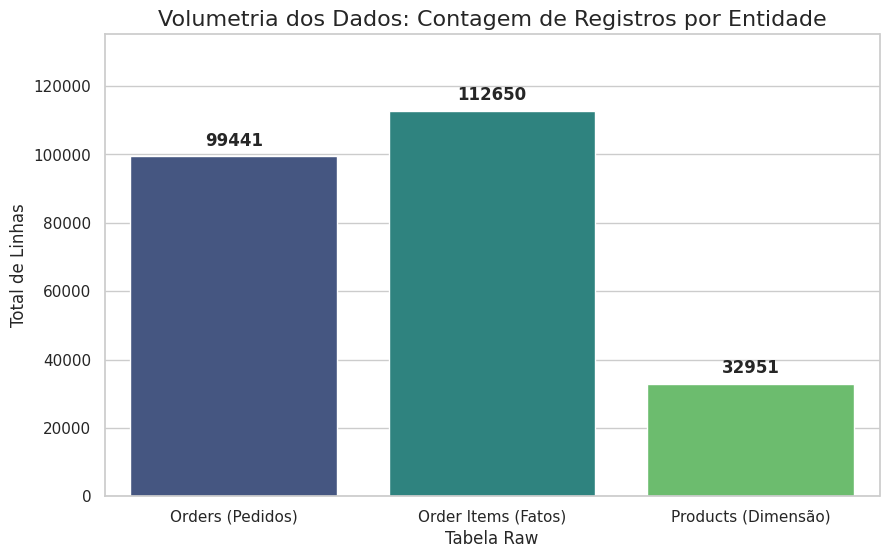

In [7]:
"""
@file analytics.ipynb
@brief Análise Exploratória e Perfilamento de Dados da Camada Raw.
@details Este script realiza a ingestão, análise de volumetria, comportamento temporal
         e auditoria de qualidade dos dados brutos do Brazilian E-commerce.
         O objetivo é validar a integridade antes do processo de ETL para a camada Silver.

@author Grupo 16
@date 2026-01-13
@version 1.0
"""
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os


sns.set_theme(style="whitegrid")


def carregar_dados(caminho="."):
    """
    @brief Carrega os datasets CSV da pasta local.
    @param caminho (str): Diretório onde os arquivos estão localizados. Default: pasta atual.
    @return tuple: Retorna 3 DataFrames (items, orders, products).
    """
     
    df_items = pd.read_csv(os.path.join(caminho, "order_items.csv"))
    df_orders = pd.read_csv(os.path.join(caminho, "orders.csv"))
    df_products = pd.read_csv(os.path.join(caminho, "products.csv"))
        
    return df_items, df_orders, df_products

df_items, df_orders, df_products = carregar_dados()

if df_orders is not None:
    
    df_volumetria = pd.DataFrame({
        'Tabela': ['Orders (Pedidos)', 
                   'Order Items (Fatos)', 
                   'Products (Dimensão)'],
        'Registros': [len(df_orders), 
                      len(df_items), 
                      len(df_products)]
    })

    plt.figure(figsize=(10, 6))
    
    ax = sns.barplot(
        data=df_volumetria, 
        x='Tabela', 
        y='Registros', 
        hue='Tabela',
        palette='viridis', 
        legend=False
    )

    plt.title('Volumetria dos Dados: Contagem de Registros por Entidade', fontsize=16)
    plt.ylabel('Total de Linhas')
    plt.xlabel('Tabela Raw')

    for container in ax.containers:
        ax.bar_label(container, 
                     fmt='%d', 
                     padding=5, 
                     fontsize=12, 
                     fontweight='bold')

    plt.ylim(0, df_volumetria['Registros'].max() * 1.2)
    plt.show()

**Observação dos Dados:**
O gráfico de barras acima apresenta a contagem total de registros nas tabelas da camada Raw.
- **Order Items:** Apresenta o maior volume (~112k linhas), o que é esperado, pois representa a tabela fato com maior granularidade (um pedido pode conter múltiplos itens).
- **Orders:** Representa a dimensão de cabeçalho dos pedidos (~99k linhas).
- **Products:** Representa o catálogo de produtos disponíveis (~32k linhas).

## 2. Análise Temporal e Sazonalidade

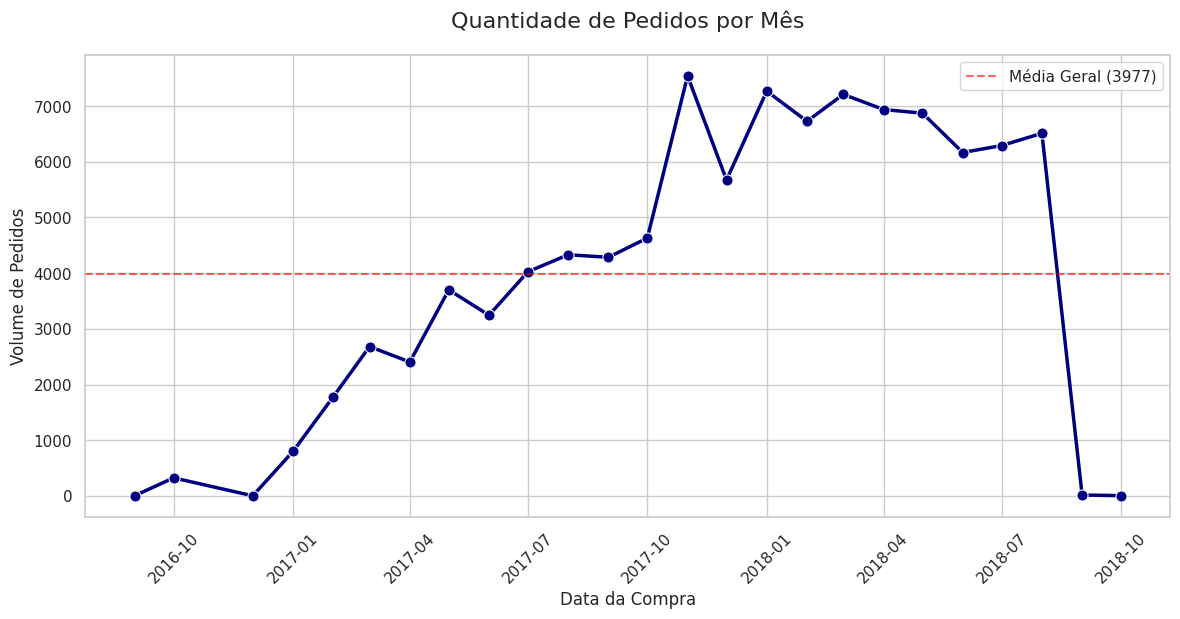

In [8]:
df_orders['order_purchase_timestamp'] = pd.to_datetime(df_orders['order_purchase_timestamp'], errors='coerce')

orders_timeline = df_orders.groupby(
                    df_orders['order_purchase_timestamp'].dt.to_period('M').dt.to_timestamp()
                ).size().reset_index(name='Qtd Pedidos')

sns.set_theme(style="whitegrid")
plt.figure(figsize=(14, 6))

sns.lineplot(data=orders_timeline, 
             x='order_purchase_timestamp', 
             y='Qtd Pedidos', 
             marker='o', 
             markersize=8, 
             color='navy', linewidth=2.5)

plt.title('Quantidade de Pedidos por Mês', fontsize=16, pad=20)
plt.xlabel('Data da Compra', fontsize=12)
plt.ylabel('Volume de Pedidos', fontsize=12)

media_pedidos = orders_timeline['Qtd Pedidos'].mean()
plt.axhline(media_pedidos, color='red', linestyle='--', alpha=0.6, label=f'Média Geral ({int(media_pedidos)})')
plt.legend()

plt.xticks(rotation=45)

plt.show()

**Técnica Aplicada:**
Foi pego a intervalo de 2016-09-04 a 2018-10-17 onde realizamos um calculo da coluna `order_purchase_timestamp` de `object` para `datetime`. Os dados foram agrupados por mês para reduzir o ruído diário e facilitar a visualização de tendências macro.

**Insights e Anomalias Identificadas:**
1.  **Falha de Continuidade (Gap de Dados):** O gráfico revela uma anomalia grave entre o final de 2016 e o início de 2017. Existem registros isolados em 2016, seguidos por meses sem nenhum dado.
    * *Diagnóstico:* Isso indica uma provável falha de ingestão histórica ou que o sistema de vendas ficou inoperante/desligado nesse período.
2.  **Tendência de Crescimento:** A partir de 2017, observa-se uma tendência de crescimento consistente, estabilizando-se em 2018.
3.  **Sazonalidade:** Nota-se um pico agressivo em Novembro/2017, correlacionado à *Black Friday*, validando a consistência dos dados com eventos reais do varejo brasileiro.

**Ação para o ETL:**
Na camada Silver, deveremos decidir se mantemos os dados esparsos de 2016 ou se filtramos a base para considerar apenas o período contínuo (a partir de Jan/2017) para evitar distorções em modelos de média móvel.

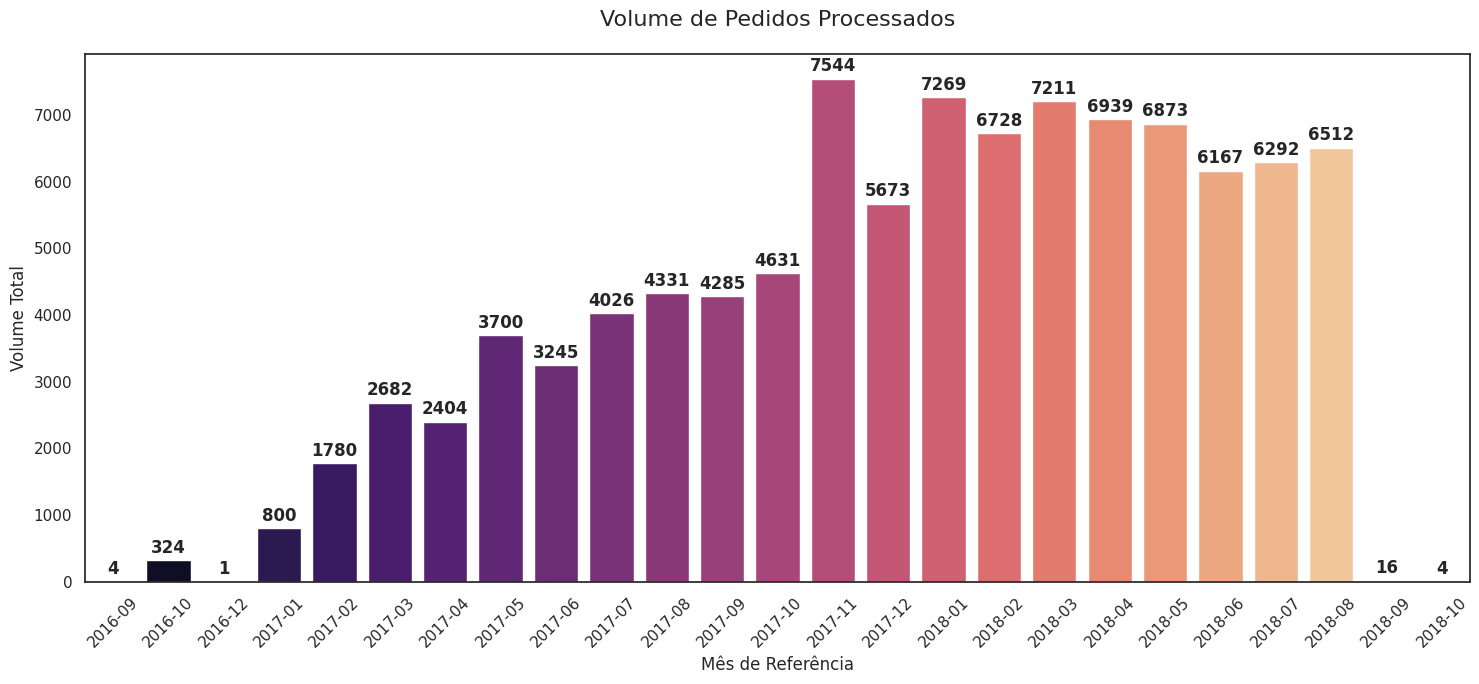

In [ ]:
orders_timeline['Periodo'] = orders_timeline['order_purchase_timestamp'].dt.strftime('%Y-%m')

sns.set_theme(style="white")
plt.figure(figsize=(15, 7))

ax = sns.barplot(data=orders_timeline, 
                 x='Periodo', 
                 y='Qtd Pedidos', 
                 palette='magma', 
                 hue='Periodo', 
                 legend=False)

plt.title('Volume de Pedidos Processados', fontsize=16, pad=20)
plt.xlabel('Mês de Referência', fontsize=12)
plt.ylabel('Volume Total', fontsize=12)
plt.xticks(rotation=45)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', 
                    (p.get_x() + p.get_width() / 2., height), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points',
                    fontweight='bold')

plt.tight_layout()
plt.show()

**Objetivo da Visualização:**
A utilização do gráfico de barras permite comparar a magnitude absoluta de vendas entre os meses, facilitando a identificação de picos sazonais que o gráfico de linha pode suavizar.

**Análise Técnica de Negócio:**
1.  **O "Efeito Black Friday":** O gráfico destaca visualmente que **Novembro de 2017** não foi apenas um pico, mas um *outlier* positivo significativo (7.5k pedidos), superando em quase 70% a média dos meses anteriores.
2.  **Consistência de 2018:** Observa-se que o primeiro semestre de 2018 manteve um patamar elevado e estável (platô), oscilando entre 6.5k e 7k pedidos/mês, indicando que a plataforma reteve o crescimento adquirido no final de 2017.
3.  **Comparativo YoY (Year over Year):** Ao comparar Jan/2017 (~800 pedidos) com Jan/2018 (~7k pedidos), notamos um crescimento exponencial de quase **9x (800%)** em um ano.

**Conclusão para Modelagem:**
A estabilidade de 2018 sugere que esse período é o mais confiável para treinar modelos preditivos de demanda, enquanto 2017 representa a fase de escala (ramp-up).

## 4. Auditoria de Qualidade dos Dados

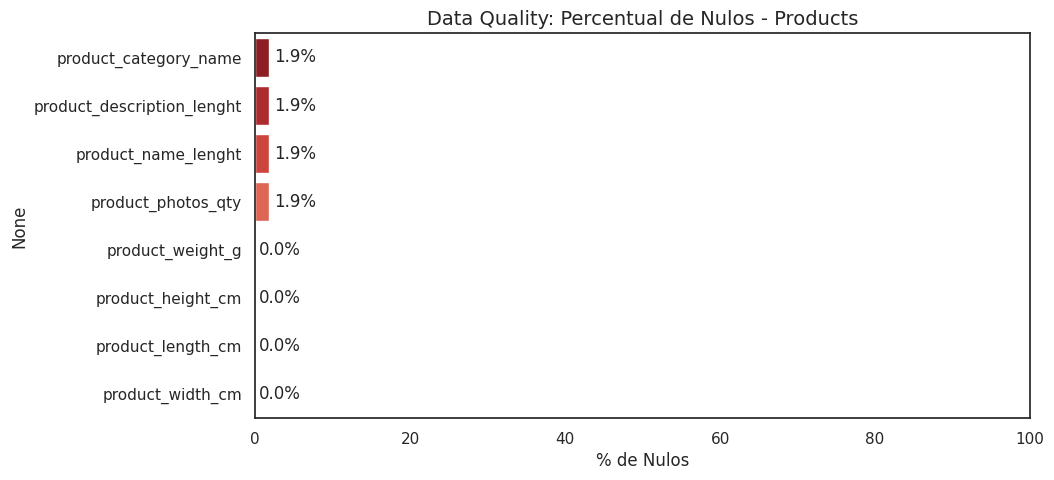

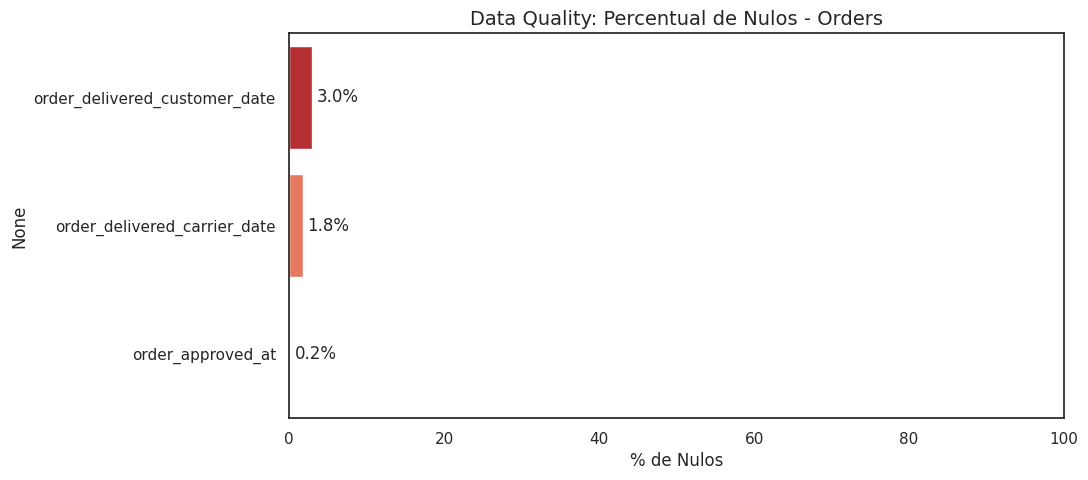

Tabela Order Items.


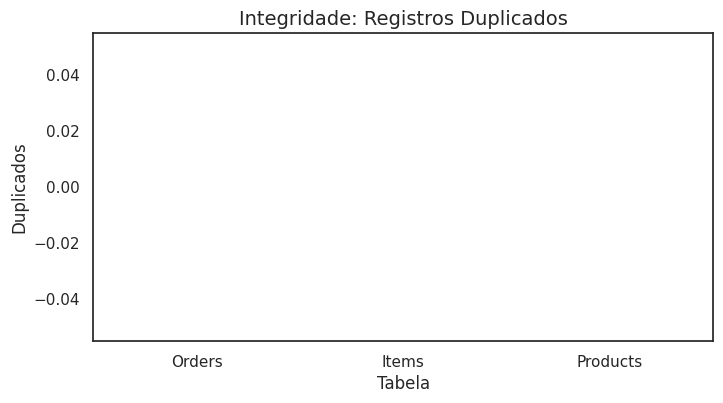

In [10]:
def plotar_nulos_corrigido(df, nome_tabela):
    """
    @brief Plota gráfico de barras horizontais com % de valores nulos.
    @param df (DataFrame): Tabela a ser analisada.
    @param nome_tabela (str): Nome para exibição no título.
    """
    nulos = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
    nulos = nulos[nulos > 0]
    
    if nulos.empty:
        print(f"Tabela {nome_tabela}.")
        return

    plt.figure(figsize=(10, 5))
    
    ax = sns.barplot(
        x=nulos.values, 
        y=nulos.index, 
        hue=nulos.index, 
        palette='Reds_r', 
        legend=False
    )
    
    plt.title(f'Data Quality: Percentual de Nulos - {nome_tabela}', fontsize=14)
    
    plt.xlabel('% de Nulos')
    plt.xlim(0, 100)
    
    for i in ax.containers:
        ax.bar_label(i, fmt='%.1f%%', padding=3)
    
    plt.show()


plotar_nulos_corrigido(df_products, "Products")
plotar_nulos_corrigido(df_orders, "Orders")
plotar_nulos_corrigido(df_items, "Order Items")

duplicatas = {
    'Orders': df_orders.duplicated().sum(),
    'Items': df_items.duplicated().sum(),
    'Products': df_products.duplicated().sum()
}

df_dup = pd.DataFrame(list(duplicatas.items()), columns=['Tabela', 'Duplicados'])

plt.figure(figsize=(8, 4))

sns.barplot(
    data=df_dup, 
    x='Tabela', 
    y='Duplicados', 
    hue='Tabela', 
    palette='Oranges_r', 
    legend=False
)

plt.title('Integridade: Registros Duplicados', fontsize=14)
plt.show()

Esta etapa visa identificar a "saúde" dos dados brutos antes de iniciarmos o processo de ETL para a camada Silver.

**4. Valores Nulos:**
A análise detectou problemas significativos na tabela `Products`:
* **Categorias Ausentes:** Cerca de **1.8%** dos produtos não possuem `product_category_name`.
* **Dados Físicos:** Medidas como peso e dimensões também apresentam nulos na mesma proporção.
* **Diagnóstico:** Como a falha ocorre em todas as colunas descritivas simultaneamente, isso indica produtos que foram cadastrados apenas com ID, mas sem metadados.

> **Nota de Engenharia:** Essas colunas exigirão regras de tratamento específicas na camada Silver, pois impactam diretamente o cálculo de frete e relatórios de categoria.

**5. Duplicidade de Registros:**
A verificação retornou **0 registros duplicados** nas tabelas principais.
* Isso valida que o processo de extração da fonte original foi bem-sucedido, não gerando lixo na camada Raw.

**6. Integridade Referencial (Chaves):**
A tabela fato `Order Items` apresentou integridade perfeita. Isso significa que toda venda está atrelada a um pedido e a um produto, garantindo que não teremos registros "órfãos" ao fazer os JOINs na modelagem dimensional.

## 5. Análise de Relacionamentos e Dispersão

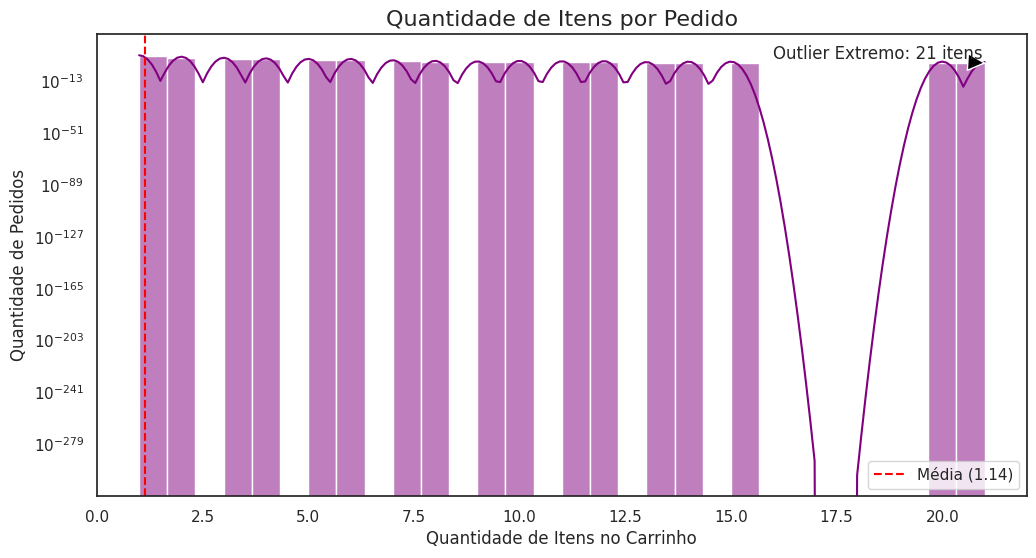

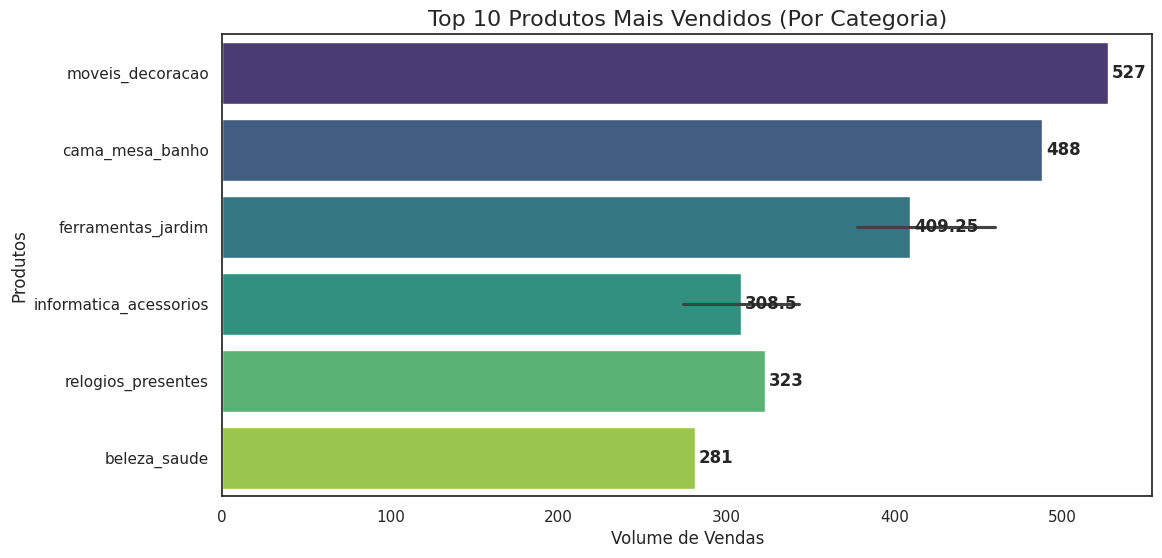

In [11]:
itens_por_pedido = df_items.groupby('order_id')['order_item_id'].count()

plt.figure(figsize=(12, 6))

sns.histplot(itens_por_pedido, 
             bins=30, 
             kde=True, 
             color='purple')

plt.title('Quantidade de Itens por Pedido', fontsize=16)
plt.xlabel('Quantidade de Itens no Carrinho')
plt.ylabel('Quantidade de Pedidos')

max_itens = itens_por_pedido.max()

media_itens = itens_por_pedido.mean()

plt.axvline(media_itens, 
            color='red', 
            linestyle='--', 
            label=f'Média ({media_itens:.2f})')

plt.annotate(f'Outlier Extremo: {max_itens} itens', 
             xy=(max_itens, 1), 
             xytext=(max_itens - 5, 1000),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.legend()
plt.yscale('log')
plt.show()

top_produtos = df_items['product_id'].value_counts().head(10).reset_index()
top_produtos.columns = ['product_id', 'Qtd Vendas']

top_produtos_enrich = top_produtos.merge(
    df_products[['product_id', 'product_category_name']], 
    on='product_id', 
    how='left'
)


top_produtos_enrich['Label'] = (
    top_produtos_enrich['product_category_name']
)

plt.figure(figsize=(12, 6))

ax = sns.barplot(
    data=top_produtos_enrich, 
    y='Label',
    x='Qtd Vendas', 
    hue='product_category_name',
    palette='viridis', 
    legend=False
)

plt.title(f'Top 10 Produtos Mais Vendidos (Por Categoria)', fontsize=16)
plt.xlabel('Volume de Vendas')
plt.ylabel('Produtos')

for container in ax.containers:
    ax.bar_label(container, 
                 padding=3, 
                 fontweight='bold')

plt.show()

**Histograma de Itens por Pedido (Detecção de Outliers):**
A distribuição apresenta uma assimetria positiva forte (Right Skewed).
* **Comportamento:** A vasta maioria dos pedidos contém apenas 1 item, o que é típico de vendas diretas ao consumidor final.
* **Anomalia:** Detectamos pedidos anômalos com mais de 20 itens.

**Concentração de Vendas:**
* Os produtos do topo possuem um volume de vendas desproporcionalmente maior que os outros.
* **Impacto:** Tabelas desse tipo podem criar gargalos de processamento em bancos distribuídos, pois todas as queries baterão nos mesmos IDs. Na camada Silver/Gold, o particionamento não deve ser feito por `product_id` para evitar partições desbalanceadas.

## 6. Análise de Distribuições Financeiras

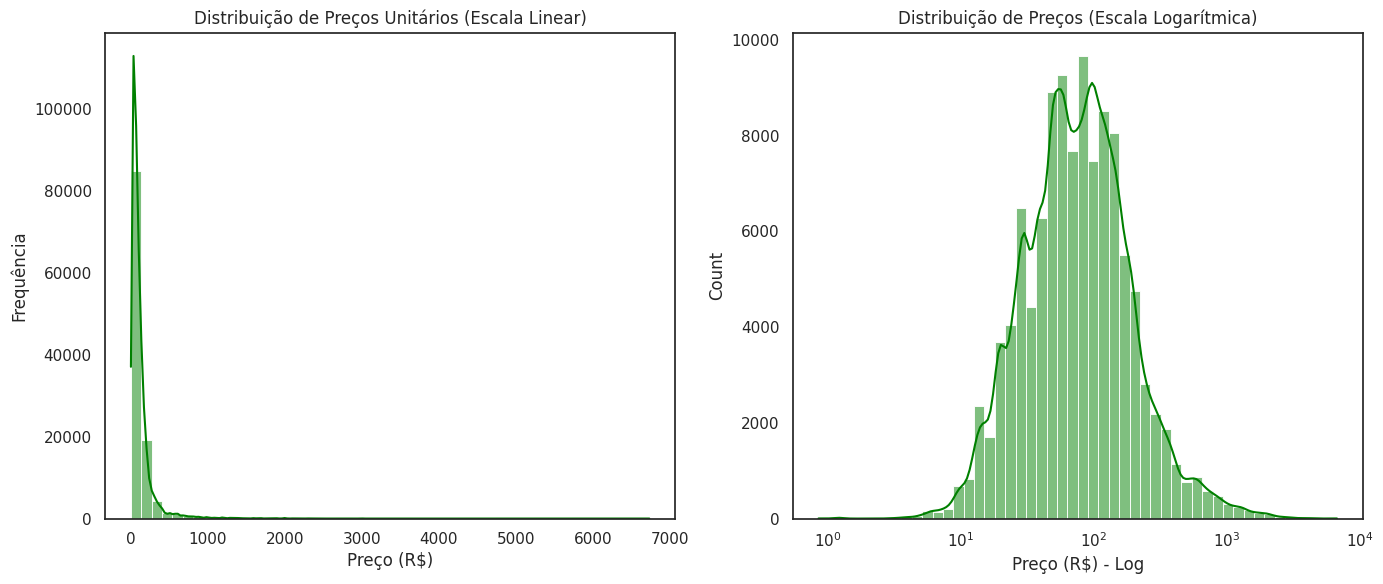

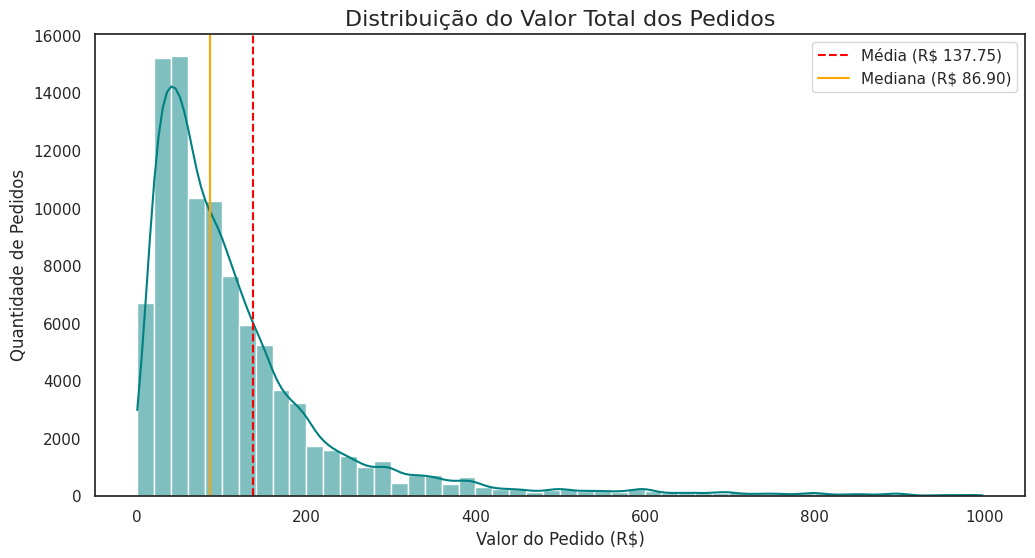

In [12]:

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(df_items['price'], 
             bins=50, 
             kde=True, 
             color='green')

plt.title('Distribuição de Preços Unitários (Escala Linear)')
plt.xlabel('Preço (R$)')
plt.ylabel('Frequência')

plt.subplot(1, 2, 2)
sns.histplot(df_items['price'], 
             bins=50, 
             kde=True, 
             color='green', 
             log_scale=True)

plt.title('Distribuição de Preços (Escala Logarítmica)')
plt.xlabel('Preço (R$) - Log')

plt.tight_layout()
plt.show()

precos_zerados = df_items[df_items['price'] == 0].shape[0]
preco_max = df_items['price'].max()

valor_pedido = df_items.groupby('order_id')['price'].sum().reset_index()
valor_pedido.columns = ['order_id', 'total_value']

plt.figure(figsize=(12, 6))

limite_visual = valor_pedido['total_value'].quantile(0.99)

dados_plot = valor_pedido[valor_pedido['total_value'] < limite_visual]

sns.histplot(dados_plot['total_value'], bins=50, kde=True, color='teal')

media_valor = valor_pedido['total_value'].mean()

mediana_valor = valor_pedido['total_value'].median()

plt.axvline(media_valor, color='red', linestyle='--', label=f'Média (R$ {media_valor:.2f})')

plt.axvline(mediana_valor, color='orange', linestyle='-', label=f'Mediana (R$ {mediana_valor:.2f})')

plt.title('Distribuição do Valor Total dos Pedidos', fontsize=16)
plt.xlabel('Valor do Pedido (R$)')
plt.ylabel('Quantidade de Pedidos')
plt.legend()
plt.show()

**Distribuição de Preços Unitários:**
* **Comportamento de Cauda Longa:** A grande maioria dos produtos custa abaixo de R$ 200,00, mas existem itens de alto valor (até R$ 6.7k) que alongam a cauda.
* **Auditoria de Zeros:** Não foram encontrados itens com preço zerado (R$ 0,00), o que valida a integridade da ingestão financeira (não há "brindes" cadastrados incorretamente como vendas).


**Valor Total do Pedido (Basket Value):**
O histograma do valor total (agrupado por `order_id`) confirma o padrão de consumo:
* **Ticket Médio vs Mediana:** A média (~R$ 137) é significativamente maior que a mediana (~R$ 89).
* **Insight de Negócio:** Isso indica que o "Ticket Médio" é puxado para cima por poucas vendas de alto valor (Outliers). Para métricas de negócio mais realistas sobre o "cliente comum", a **Mediana** é uma métrica mais robusta.